# Factorización y ordenamiento de SOS
<img src="./img/logo_UTN.svg" align="right" width="150" /> 

#### Por Mariano Llamedo Soria

### Resumen 
En este documento se analiza una función transferencia pasabanda de orden 6, aprovechando las posibilidades de factorización y ordenamiento de secciones de segundo orden (SOS). Para ello se utiliza un ejemplo del libro de Schaumann, donde se comparan los resultados obtenidos y finalmente se implementa circuitalmente dicha transferencia.
Al mismo tiempo, se dan ejemplos de las siguientes funciones para el análisis y manipulación de funciones transferencia:

* Análisis de la respuesta en frecuencia: [analyze_sys](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.analyze_sys)
* De presentación algebraica: [print_latex](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/general/index.html#pytc2.general.print_latex), [a_equal_b_latex_s](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/general/index.html#pytc2.general.a_equal_b_latex_s), [pretty_print_SOS](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.pretty_print_SOS)
* De manipulación de sistemas lineales: [tf2sos_analog](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.tf2sos_analog)


### Introducción

A lo largo del curso se presentó una metodología sistemática para arribar a una función transferencia $T(s)$ a partir de restricciones de la función de módulo $\vert T(j\omega) \vert $ o retardo $ \tau(\omega) $. Si bien en primera instancia arribamos a una $T_{LP}(s)$ pasabajos, es posible mediante núcleos de transformación el pasaje a otro tipo de transferencias (pasa-alto, pasabanda, etc).

$$ T_{G}(s) = T_{Lp}(p)\Big\vert_{p = K_{G}} $$


Obteniendo una función transferencia generalizada $ T_{G}(s) $ que sigue las restricciones originales de módulo o retardo. Este tipo de funciones alcanza fácilmente órdenes mucho mayores a 2, es decir el de las funciones bicuadráticas que ya fueron explicadas en detalle. Recordar que  la finalidad de estudiar funciones bicuadráticas y bilineales, en definitiva, es llegar fácil y sistemáticamente a una red eléctrica que implemente dichas funciones elementales, y así llegar a la función de orden superior a partir de la factorización matemática, o su equivalente interconexión eléctrica. En ese sentido se plantea la factorización de la función $ T^p_{G}(s) = K.\prod_j T^p_j(s)$ cuando sea de orden par, y $ T^i_{G}(s) = K.T^i_0(s) \prod_j T^p_j(s)$ cuando sea de orden impar. Cabe mencionar que el superíndice $p$ indica orden par y el $i$, impar o (bi) lineal en este caso. Dicha factorización, eléctricamente significa la cascada de secciones bicuadráticas (SOS) y, eventualmente para los órdenes impares, una sección bilineal. Del mismo modo, la amplificación $K = \prod^J_j k_j$ será también distribuída entre las $J$ secciones con un criterio que se explicará más abajo.

La factorización que se presentó conlleva una decisión de ingeniería de **relativa complejidad**, que es el ordenamiento de las SOS. Está claro que el ordenamiento de las secciones no tiene importancia matemática, sino que persigue la **maximización del rango dinámico**, es decir, evitar que la señal sea innecesariamente atenuada o amplificada de forma tal que sea distorsionada. El orden óptimo resultará de un análisis heurístico que conlleva un costo computacional de crecimiento combinatorio respecto al orden de la función $ T_{G}(s) $. Esto es ciertamente **difícil o imposible** para órdenes moderadamente elevados, sin ayuda de software específico o un relajamiento de las restricciones de optimicidad. En este sentido, Schaumann en su libro plantea los siguientes criterios que permiten obtener un ordenamiento comparable al óptimo (Cap. 5.3):

1. Seleccionar para cada SOS  los polos y ceros más próximos entre sí, de forma tal que la respuesta en frecuencia $\vert T_j(j\omega) \vert$ sea lo más plana posible.

2. Ordenar de entrada a salida con SOS de $Q$ creciente. Es decir, Si $Q_j$ es el Q de la *j-ésima* sección, las primeras secciones (de la entrada a la salida) serán aquellas con menor Q, de forma tal que $Q_0 < Q_1 < ... < Q_J$ para las $J$ secciones.

3. La asignación de ganancias tiene cierta complejidad, y se refiere al lector interesado al libro de Schaumann 5.3 para más detalles, o al código fuente de la función [tf2sos_analog]() para una implementación. En resumen, asignar a la primera sección 

$$k_1= K. \frac{M_n}{M_1} $$

siendo 

$$ M_n = \mathrm{max}_w \prod^n_{j=1} \vert t_j(j\omega) \vert. $$

 Se entiende $M_n$ como la productoria de los máximos de las transferencias parciales hasta la n-ésima sección. Las siguientes secciones tendrán una ganancia asignada de 

$$k_j= \frac{M_{j-1}}{M_j}, \,\, j=2, ..., n $$

Con esta asignación se busca que las salidas de **todas las etapas parciales** estén en sus máximos al momento que la transferencia total esté en su máximo. 

De esta manera se llega a la factorización buscada

$$ T_{G}(s) = \prod^J_j k_j . \frac{ \alpha_{2j}.s^2 + \alpha_{1j}.s + \alpha_{0j} }{ s^2 + s \frac{\omega_{0j}}{Q_j} + \omega^2_{0j} } $$


### Ejemplo 5.13 del libro de Schaumann

Sea la función transferencia 

$$ T(s) = \frac{ s^5 + 2.5 s^3 + 0.5625 s }{ s^6 + 0.39 s^5 + 3.067 s^4 + 0.785 s^3 + 3.056 s^2 + 0.387 s + 0.989} $$


In [1]:
# Módulos externos
import numpy as np
import matplotlib as mpl
import scipy.signal as sig
import matplotlib.pyplot as plt

fig_sz_x = 13
fig_sz_y = 7
fig_dpi = 80 # dpi

fig_font_size = 11

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi
plt.rcParams.update({'font.size':fig_font_size})



In [2]:
# Ahora importamos las funciones de PyTC2

from pytc2.sistemas_lineales import analyze_sys, pretty_print_lti, tf2sos_analog, pretty_print_SOS
from pytc2.general import print_latex, print_subtitle


In [3]:
# Comienzo de la simulación

# definimos la función transferencia
num = np.array([1, 0, 2.5, 0, 0.5625, 0])
den = np.array([1, 0.390, 3.067 , 0.785, 3.056, 0.387, 0.989])

pretty_print_lti(num, den)


<IPython.core.display.Math object>

como se desconoce la característica de la transferencia, se comienza por una inspección visual

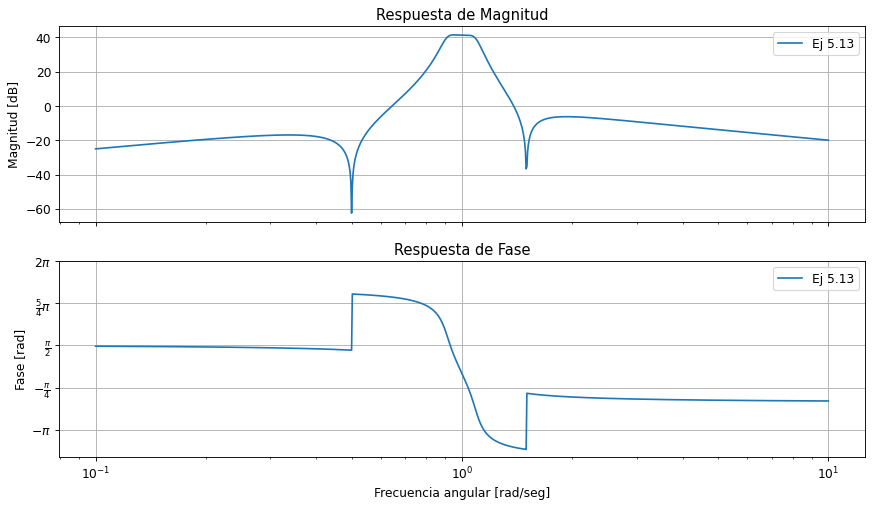

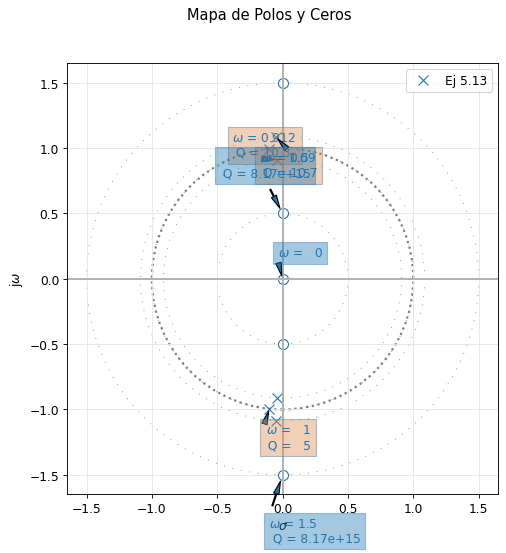

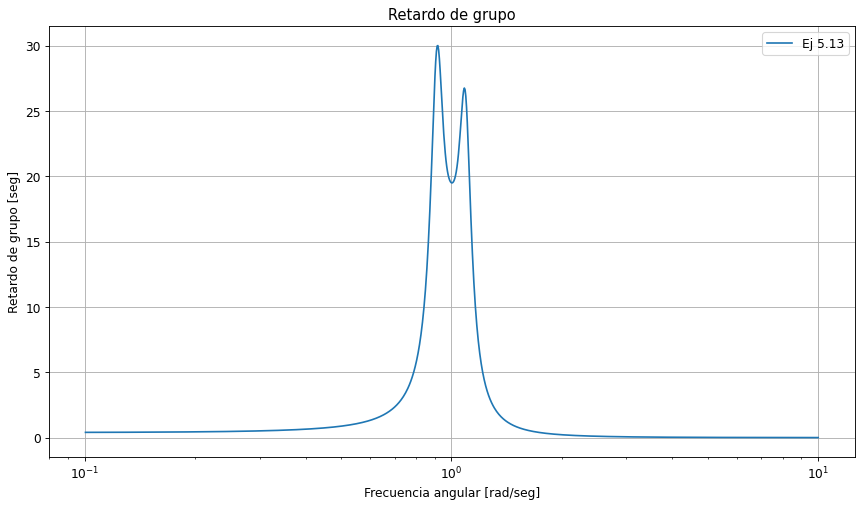

In [4]:

# el caracter "_" descarta la salida de la función
_ = analyze_sys( sig.TransferFunction(num, den), 'Ej 5.13' )


de la transferencia se observa que para $\omega = 1$ r/s cuenta con 41.3 dB. Este valor según el enunciado **se requiere que sea de 10 dB**. Por este motivo se corrige la ganancia de la transferencia disminuyéndola 31.3 dB.

In [5]:
# ganancia original para w = 1 en dB
k0db = 41.3

# k0 deseada en el ejemplo en dB
k0_deseada = 10 

# factor de corrección de ganancia
k_corr = 10**((k0_deseada - k0db)/20)

# corrección de ganancia
num = k_corr * num

Ahora podemos comenzar con el análisis y la factorización en SOS's.

In [6]:
from IPython.display import display, Markdown

display(Markdown('### Ejemplo 5.13 del Schaumann: Factorización en secciones de segundo orden' ))

print_subtitle('Función transferencia con 10 dB')

pretty_print_lti(num, den)

# particiono en SOS's para la implementación
sos_pb = tf2sos_analog(num, den)

# ajusto posibles problemas numericos (negativos y valores despreciables)
# asumimos siempre transferencias normalizadas.
sos_pb[sos_pb < 1e-6] = 0.0

print_subtitle('Transferencia factorizada')

# visualizamos la transferencia factorizada
pretty_print_SOS(sos_pb)

print_subtitle('Transferencia factorizada y parametrizada')

# visualizamos la transferencia factorizada y parametrizada
pretty_print_SOS(sos_pb, mode='omegayq')



### Ejemplo 5.13 del Schaumann: Factorización en secciones de segundo orden

#### Función transferencia con 10 dB

<IPython.core.display.Math object>

#### Transferencia factorizada

<IPython.core.display.Math object>

#### Transferencia factorizada y parametrizada

<IPython.core.display.Math object>

Finalmente analizamos la transferencia de cada SOS y la implementación resultante total

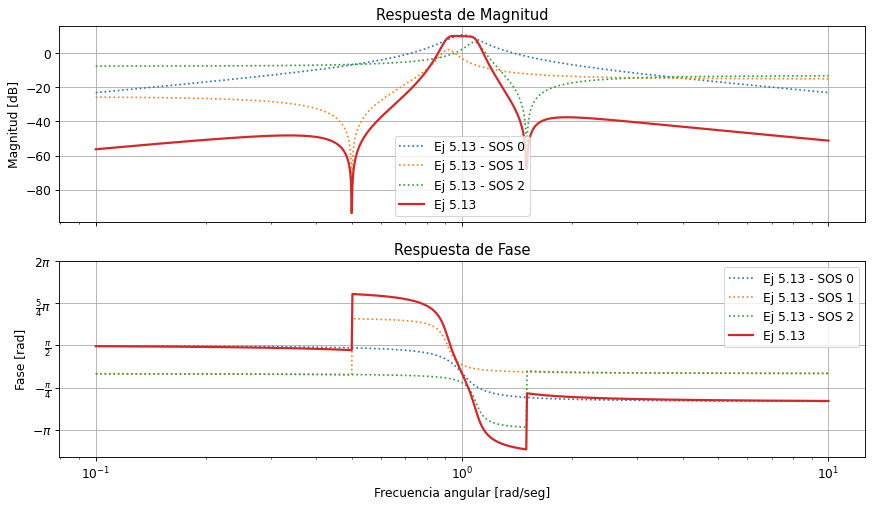

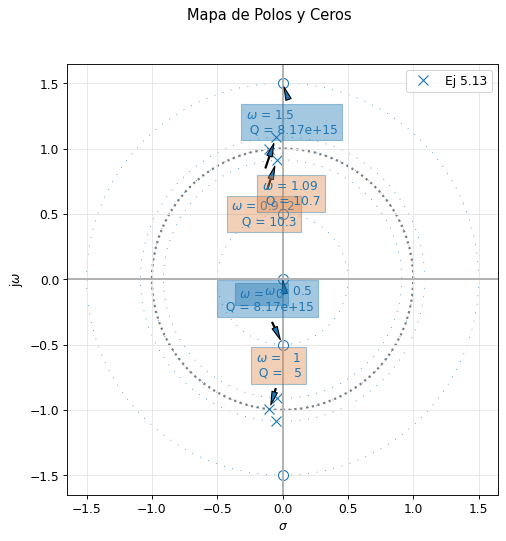

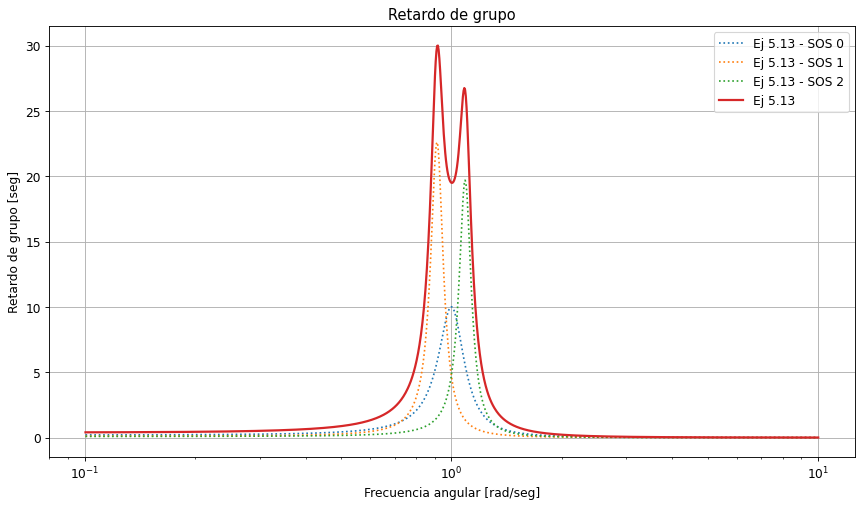

In [7]:

# el caracter "_" descarta la salida de la función
_ = analyze_sys( sos_pb, 'Ej 5.13' )


De los resultados obtenidos del análisis se puede verificar el procedimiento explicado:

* se verifica que $\vert T_G(j\omega) \vert$ satisface el comportamiento de la función original y la ganancia en la banda de paso de 10 dB

* La factorización obtenida mediante [tf2sos_analog]() respeta los lineamientos de ordenamiento

    1. Apareamiento de cada SOS polo-cero más próximo: ver diagrama de polos y ceros.
    2. Q creciente: 5 - 10.32 - 10.73
    3. Ganancia decreciente para maximizar el rango dinámico. Restaría hacer una simulación circuital

* La factorización [pretty_print_bicuad_omegayq]() facilita la interpretación de los parámetros constructivos de cada SOS. Por ejemplo la primera sección será un **pasabanda** con los siguientes parámetros:
    
    1. $\omega_10 = 1.002 \approx 1$ r/s
    2. $Q_1 \approx 5$
    3. $k_1 \approx 6.5$
    
* Una vez parametrizada cada SOS, resta elegir el circuito que lo implementará. Para este ejemplo Schaumann sugiere redes Ackerberg-Mossberg como los de la figura

![Ej5.13](img/5.13_ack_moss.jpg)


A modo de ampliar un poco el ejemplo, se propone implementar el mismo filtro mediante el conversor generalizado de imitancias (GIC) de Antoniou. Para ello se simula en LTspice el ordenamiento analizado más arriba:

![Ej5.13_LTspice](img/5.13_GIC.png)

Podemos notar que cada etapa  se implementará mediante la estructura GIC en su versión bicuad:

![GIC_bicuad](img/GIC_bicuad.png)

Y la transferencia total, como cada una de las parciales se puede observar en el siguiente gráfico

![GIC_transfer](img/5.13_transfer.png)

![GIC_transfer_detail](img/5.13_transfer_detail.png)

